In [2]:
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian') + ['\n', '\r'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(morph.normal_forms(word)[0] for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from sklearn.decomposition import LatentDirichletAllocation
import collections, re
from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
!pip install catboost
from catboost import CatBoostClassifier

In [8]:
data = pd.read_csv('/content/prepairing_data_patch.csv')

In [9]:
picabu = pd.read_csv('/content/labeled.csv')

In [10]:
task2 = pd.read_csv('/content/hui.csv')

In [12]:
ok = pd.read_csv('/content/Ok.csv', sep=';', index_col='id').iloc[:20000]
ok['label'] = ok.label.apply(lambda x: 0 if x == 'NORMAL' else 1)
ok.head()

,label,text,Unnamed: 3,Unnamed: 4
id,,,,
41127,1,дворника надо тоже уничтожить!,NaN,NaN
6812,0,"моя старшая неделю шипела, не принимала подкид...",NaN,NaN
6256,0,полностью с вами согласна!,NaN,NaN
189636,0,"хоть ногу вверх, ничего не изменится",NaN,NaN
99053,0,а что значит - левого ребенка?,NaN,NaN


In [13]:
texts = pd.read_csv('/content/non-toxic.txt',  sep=';',header=None)
neg_texts = pd.read_csv('/content/toxic.txt',  sep=';',header=None)
neg_texts[0].values

array(['Я ненавижу <identity>.', 'Все <identity> тупые уроды.',
       '<identity> сосет хуй.',
       'Автор, гори в аду за пост об <identity>.',
       'Не ожидала, что админ такой тупой, что запостит <identity>.',
       'Ебать, продался <identity>.',
       'Ненавижу этих дебилов из <identity>.',
       '<identity> сдохни и гори в аду.',
       'Кайф обоссать этого <identity>.', 'Получай по ебалу <identity>.',
       'Тупые жирные <identity>, я вас ненавижу.',
       'Умри, бесполезный <identity>.',
       'Ты че решил что ты самый умный <identity>?',
       'Дружочек, я с <idenity> не разговаривал.',
       'Ну если мне понадобится мнение тупого <identity>, я позову твоего отца.',
       'Выглядит странно как будто <identity> совсем ебнулся.',
       'Кому-то еще не очевидна тупость <identity>?',
       'На <identity> подписаны только тупицы.'], dtype=object)

In [14]:
secured_words = pd.read_csv('/content/prot.txt').word.values
positivs = []
negativs = []
for word in secured_words:
  for sentence in texts[0].values:
    positivs.append(sentence.replace('<identity>', word))
  for sentence in neg_texts[0].values:
    negativs.append(sentence.replace('<identity>', word))


In [15]:
positives = pd.DataFrame(data=positivs, columns=['message'])
positives['label'] = 0
negatives = pd.DataFrame(data=negativs, columns=['message'])
negatives['label'] = 1

In [16]:
data['text'] = data.apply(lambda row: preprocess(row.message), axis=1)
positives['text'] = positives.apply(lambda row: preprocess(row.message), axis=1)
negatives['text'] = negatives.apply(lambda row: preprocess(row.message), axis=1)
task2['text'] = task2.apply(lambda row: preprocess(row.message), axis=1)
picabu['text'] = picabu.apply(lambda row: preprocess(row.comment), axis=1)
ok['text'] = ok.apply(lambda row: preprocess(row.text), axis=1)

In [17]:
train = data[data['split']=='train']
test = data[data['split']=='valid']

In [18]:
train

,message,label,split,text
0,Пиздабол ещё тот,1,train,пиздабол ещё
1,"Заколебали кукарекать, скоро весь пульс будет ...",1,train,заколебать кукарекать скоро весь пульс вафлера...
2,На деле собака сутулая,1,train,дело собака сутулый
3,Пшнх от сюда тварь,1,train,пшнх сюда тварь
4,"плати за мое молчание клоп , сутки молчу 200 б...",1,train,платить молчание клоп сутки молчать бакс
...,...,...,...,...
34602,"Тут не то, что ТА не работает, здравый смысл о...",0,train,работать здравый смысл отсутствовать
34603,Я тоже в бакс по 30 верил\nКогда он уже 50 сто...,0,train,бакс верить стоить
34604,"Ахаха, тока щас заметил что за это гавно комис...",0,train,ахах ток заметить это гавный комиссия конский ...
34605,"Я с Теслой месяц мучился с плечом , в итоге вс...",0,train,теслой месяц мучиться плечо итог всё норма дож...


In [19]:
X_train = pd.concat((train.text.fillna(''), #positives.text.fillna(''), negatives.text.fillna(''), task2.text.fillna(''), 
                     picabu.text,
                     ok.text
                     ),axis=0, ignore_index=True)
y_train = pd.concat((train.label, #positives.label, negatives.label, task2.label.astype(int), 
                     picabu.toxic.astype(int),
                     ok.label
                     ),axis=0, ignore_index=True)
X_test = test.text.fillna('')
y_test = test.label

## RNN


In [ ]:
X_train = pd.DataFrame(data=pd.read_csv('/content/X_train.csv').fillna('').values, columns=['message']).message
X_test = pd.DataFrame(data=pd.read_csv('/content/X_test.csv').fillna('').values, columns=['message']).message
y_train = pd.DataFrame(data=pd.read_csv('/content/y_train.csv').fillna('').values, columns=['message']).message
y_test = pd.read_csv('/content/y_test.csv')


In [ ]:
words = set()
max_len = -1
for line in X_train:
  words.update(line.split())
  if len(line) > max_len:
    max_len = len(line)
word_to_id = {}
for i, val in enumerate(list(words) + ['']):
  word_to_id[val] = i


def token_to_id(name):
  if name in word_to_id:
    return word_to_id[name] / max_len
  return -1

In [ ]:
word_to_id['']

105270

In [ ]:
len(word_to_id)

105271

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id(''), dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    #print('here')
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id(c) for c in names[i].split()][:max_len]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
train_data = to_matrix(X_train, max_len=300)

In [ ]:
train_data.shape

(190888, 300)

In [ ]:
batch_ix = to_matrix(X_train[:5], max_len=300)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

rnn = nn.RNN(10, 10)

logp_seq = rnn(batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

RuntimeError: ignored

In [ ]:
batch_ix.shape

torch.Size([5, 300])

In [ ]:
from torch import nn
import torch

rnn = nn.RNN(300, 2, 12)

input = batch_ix[np.newaxis, :, :].float()
h0 = torch.zeros(12, 64, 2)
output, hn = rnn(input, h0)

RuntimeError: ignored

In [ ]:
X_train

0                                              пиздабол ещё
1         заколебать кукарекать скоро весь пульс этот ва...
2                                       дело собака сутулый
3                                           пшнх сюда тварь
4              платить мой молчание клоп сутки молчать бакс
                                ...                        
190883    думать полиция это знать просто это никто хоте...
190884                           возмущаться всё точно факт
190885    затереть дыра данный ролик сколько год всё пок...
190886                            проследить пидор наказать
190887                                     редкий долбоести
Name: message, Length: 190888, dtype: object

In [ ]:
output

tensor([[-3.4993e-01, -3.0756e-01, -2.7500e-01,  1.1932e-03, -1.7987e-01,
         -1.3807e-01,  1.0722e-02,  3.0190e-01, -9.9065e-02, -1.4211e-01,
         -6.3561e-01, -1.4722e-01, -3.9479e-01, -3.7867e-01, -7.1260e-02,
          2.0672e-01,  1.2577e-01, -3.2960e-01,  3.5796e-01,  2.7854e-01,
         -4.3397e-01, -1.4973e-02, -1.9574e-01,  3.1353e-01, -2.2685e-01,
          1.9929e-02,  4.0099e-01,  1.3460e-01,  7.5548e-03,  1.5212e-01,
         -2.1347e-01, -1.2314e-01,  4.7164e-01,  2.5409e-01,  4.4845e-01,
          1.9260e-01, -2.7073e-01, -2.0794e-01,  7.3013e-01,  1.0160e-01,
         -2.6584e-01, -3.6435e-01,  7.3061e-02, -3.9773e-01, -1.0634e-01,
         -1.9774e-01, -4.3082e-02,  2.9453e-01, -6.7992e-01, -4.7794e-01,
         -3.0099e-01, -5.4821e-01,  7.8595e-02,  2.4260e-01, -3.3104e-01,
         -9.4799e-03,  4.5769e-02,  3.2028e-01,  2.1499e-01,  2.7773e-01,
          1.8513e-01, -3.6358e-01, -1.5184e-01, -1.3534e-01, -4.6190e-05,
          9.6920e-02, -6.7579e-02,  3.

In [ ]:
output[:, :, 0]

IndexError: ignored

In [ ]:
X_train[[1, 2, 3]]

1    заколебать кукарекать скоро весь пульс этот ва...
2                                  дело собака сутулый
3                                      пшнх сюда тварь
Name: message, dtype: object

In [ ]:
criterion()

In [ ]:
actual_next_tokens.values.reshape(-1).shape

NameError: ignored

In [ ]:
np.array([1, 2, 3]).shape,  predictions_logp.shape

((3,), torch.Size([1, 64]))

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
cosine(navec.get('король') - navec.get('мужчина') + navec.get('женщина'), navec.get('королева'))

0.26030921936035156

In [ ]:
input.shape

torch.Size([1, 64, 300])

In [ ]:
line_ix

NameError: ignored

In [ ]:
def to_matrix(names, max_len=None, pad=navec.get(''), dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    #print('here')
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len, 300], dtype='float64')

    for i in range(len(names)):
        line_ix = np.zeros((max_len, 300)) 
        for i, c in enumerate(names[i].split()):
          line_ix[i, :] = navec.get(c)
          if i == max_len - 1:
            break
        #print(line_ix.shape)
        names_ix[i, :, :] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
predictions_logp.shape, actual_next_tokens.shape

NameError: ignored

In [ ]:
a = np.zeros((2, 3, 2))
b = np.ones((2, 2))

a[0,0:len(b), :] = b
a

In [ ]:
batch_ix.shape

In [ ]:
predictions_logp.shape, actual_next_tokens.shape

NameError: ignored

In [ ]:
predictions_logp[0]

NameError: ignored

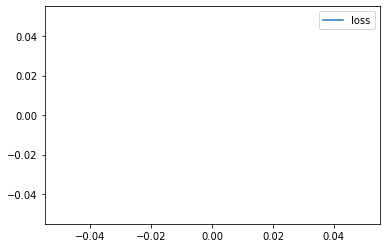

 13%|█▎        | 126/1000 [02:05<14:15,  1.02it/s]

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
import torch, torch.nn as nn

MAX_LENGTH = 300
rnn = nn.RNN(300, 1, 50)
criterion = nn.MSELoss()

h0 = torch.zeros(50, 300, 1)

opt = torch.optim.Adam(rnn.parameters())
history = []

for i in tqdm(range(1000)):
    indexes = np.random.randint(0, len(X_train), 300)
    batch_ix = to_matrix(X_train[indexes].values, max_len=MAX_LENGTH)
    actual_values = y_train[indexes]
    input = torch.Tensor(batch_ix).float()
    
    output, h0 = rnn(input, h0)
    h0 = h0.detach()
    
    # compute loss
    predictions_logp = output[:, 0, 0] # YOUR CODE HERE
    actual_next_tokens = actual_values # YOUR CODE HERE

    loss = criterion(predictions_logp, torch.Tensor(actual_next_tokens.values)) # YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
h0

tensor([[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]])

In [ ]:
loss

tensor(nan, grad_fn=<MseLossBackward>)

In [ ]:
rnn.eval()
h0 = torch.zeros(50, 256, 1)
y_pred = []
for i in range(0, len(X_test), 64):
  batch_ix = to_matrix(X_test[i:i+64].values, max_len=300)
  input = torch.Tensor(batch_ix[np.newaxis, :, :]).float()
  if input.shape[1] == 256:
    output, _ = rnn(input, h0)
    for k in output.reshape(-1):
      y_pred.append(float(k))
for i in range(58):
  y_pred.append(np.nanmean(y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [ ]:
input, output.reshape(-1)

(tensor([[[ 1.8620, 14.7320, 17.8092,  ..., 17.8092, 17.8092, 17.8092],
          [-1.0000, 16.0140,  5.8672,  ..., 17.8092, 17.8092, 17.8092],
          [16.0421,  9.6369, 11.0519,  ..., 17.8092, 17.8092, 17.8092],
          ...,
          [13.4945,  0.9242,  3.7975,  ..., 17.8092, 17.8092, 17.8092],
          [14.5343,  9.3477,  1.8794,  ..., 17.8092, 17.8092, 17.8092],
          [15.3465,  9.7006, 17.4612,  ..., 17.8092, 17.8092, 17.8092]]]),
 tensor([0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,
         0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705, 0.1705,

In [ ]:
y_pred

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
len(y_pred)

58

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
roc_auc_score(y_test, y_pred)

ValueError: ignored

In [ ]:
import catboost
cats = CatBoostClassifier()
cats.load_model('/content/catboost_055.model')

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([i for i in np.arange(0, 1, 0.01)], [i for i in np.arange(0, 1, 0.01)])

ValueError: ignored

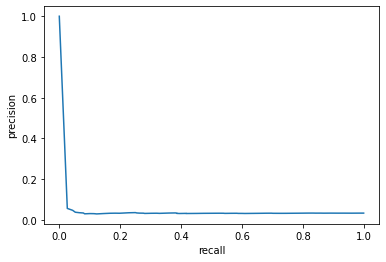

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [ ]:
np.nanmax(2 * recall * precision / (recall + precision)), thresholds[np.nanargmax(2 * recall * precision / (recall + precision))]

(0.063919259882254, 0.06956557929515839)

In [ ]:
float(a)

0.11235255002975464

## Вики

In [ ]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp37-none-any.whl size=11686 sha256=f0e173923632494f21391d6921ad340566690181cd555210c340dc2ebc34e10d
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [ ]:
import wikipedia
wikipedia.set_lang('RU')
print(wikipedia.summary("Википедия"))

Википе́дия (англ. Wikipedia, произносится [ˌwɪkɨˈpiːdiə] или [ˌwɪkiˈpiːdiə]) — общедоступная многоязычная универсальная интернет-энциклопедия со свободным контентом, реализованная на принципах вики. Расположена по адресу wikipedia.org.
Владелец сайта — американская некоммерческая организация «Фонд Викимедиа», имеющая 37 региональных представительств. Название энциклопедии образовано от английских слов wiki («вики»; в свою очередь заимствовано из гавайского языка, в котором оно имеет значение «быстро») и encyclopedia («энциклопедия»).
Запущенная в январе 2001 года Джимми Уэйлсом и Ларри Сэнгером, Википедия сейчас является самым крупным и наиболее популярным справочником в Интернете. По объёму сведений и тематическому охвату Википедия считается самой полной энциклопедией из когда-либо создававшихся за всю историю человечества. Одним из основных достоинств Википедии как универсальной энциклопедии является возможность представления информации на родном языке пользователя.
На май 2018 года 

## Катбуст

In [ ]:
#X_train = pd.DataFrame(data=pd.read_csv('/content/X_train.csv').fillna('').values, columns=['message']).message[:60000]
#X_test = pd.DataFrame(data=pd.read_csv('/content/X_test.csv').fillna('').values, columns=['message']).message
#y_train = pd.DataFrame(data=pd.read_csv('/content/y_train.csv').fillna('').values, columns=['message']).message[:60000]
#y_test = pd.read_csv('/content/y_test.csv')


In [26]:
X_train

0                                             пиздабол ещё
1        заколебать кукарекать скоро весь пульс вафлера...
2                                      дело собака сутулый
3                                          пшнх сюда тварь
4                 платить молчание клоп сутки молчать бакс
                               ...                        
62108                             идеал хамство самомнение
62109                   господь красиво живой золотой рука
62110    муж ехать свободный место выезд далматово мочь...
62111                         вкусно истоить весь коппейка
62112                           открыться граница ураааааа
Name: text, Length: 62113, dtype: object

In [27]:
vectorizer = TfidfVectorizer(max_features=10000, norm='l1')
tfidf_train = np.asarray(vectorizer.fit_transform(X_train).todense())
tfidf_test = np.asarray(vectorizer.transform(X_test).todense())

In [88]:
cat = CatBoostClassifier(random_state=228, #loss_function='CrossEntropy', 
                         learning_rate=0.2, iterations=2000, #depth=6, 
                         task_type='GPU')

In [89]:
from scipy import sparse

In [90]:
cat.fit(sparse.csr_matrix(tfidf_train), y_train, eval_set=(sparse.csr_matrix(tfidf_test), y_test))

0:	learn: 0.5701754	test: 0.5364643	best: 0.5364643 (0)	total: 85.4ms	remaining: 2m 50s
1:	learn: 0.4961244	test: 0.4346642	best: 0.4346642 (1)	total: 168ms	remaining: 2m 48s
2:	learn: 0.4458650	test: 0.3630228	best: 0.3630228 (2)	total: 253ms	remaining: 2m 48s
3:	learn: 0.4161207	test: 0.3160137	best: 0.3160137 (3)	total: 341ms	remaining: 2m 49s
4:	learn: 0.3955054	test: 0.2823733	best: 0.2823733 (4)	total: 416ms	remaining: 2m 45s
5:	learn: 0.3805442	test: 0.2581298	best: 0.2581298 (5)	total: 491ms	remaining: 2m 43s
6:	learn: 0.3670557	test: 0.2325402	best: 0.2325402 (6)	total: 557ms	remaining: 2m 38s
7:	learn: 0.3583320	test: 0.2202144	best: 0.2202144 (7)	total: 627ms	remaining: 2m 36s
8:	learn: 0.3526019	test: 0.2105751	best: 0.2105751 (8)	total: 694ms	remaining: 2m 33s
9:	learn: 0.3475816	test: 0.2031905	best: 0.2031905 (9)	total: 765ms	remaining: 2m 32s
10:	learn: 0.3419020	test: 0.1935466	best: 0.1935466 (10)	total: 826ms	remaining: 2m 29s
11:	learn: 0.3380941	test: 0.1890139	bes

In [96]:
pred = cat.predict(sparse.csr_matrix(tfidf_test))
print('F1 on cat:', f1_score(pred, y_test))

F1 on cat: 0.5693069306930694


In [87]:
cat.save_model('catboost_055.model')

In [97]:
y_pred = cat.predict_proba(sparse.csr_matrix(tfidf_test))[:, 1]
y_pred_cat = cat.predict_proba(sparse.csr_matrix(tfidf_test))[:, 1]

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve

In [99]:
roc_auc_score(y_test, y_pred)

0.9451416145184764

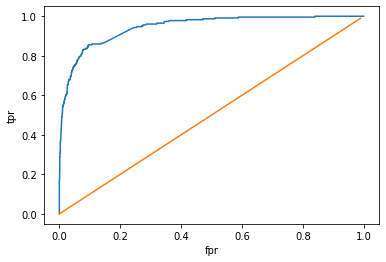

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([i for i in np.arange(0, 1, 0.01)], [i for i in np.arange(0, 1, 0.01)])

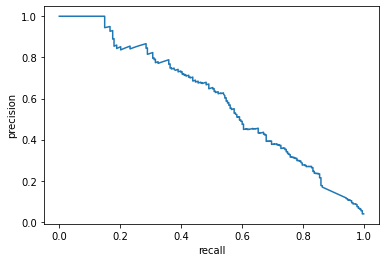

In [101]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [102]:
np.nanmax(2 * recall * precision / (recall + precision)), thresholds[np.nanargmax(2 * recall * precision / (recall + precision))]

(0.580188679245283, 0.44722135272772223)

In [103]:
cat.save_model('best.model')

In [20]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Conv2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional, Flatten, BatchNormalization, LSTMCell, RNN, GRU
import tensorflow as tf
%matplotlib inline 

In [21]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

In [91]:
from sklearn.utils import shuffle

num_words = 40000
max_news_len = 10

def preprocess_cnn(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    return ' '.join(text)


text_train = pd.read_csv("train_new.csv").dropna().text
text_test = pd.read_csv("test_new.csv").fillna('').text.apply(lambda x: preprocess_cnn(x))
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(text_train)

In [92]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 124, input_length=max_news_len))
model_cnn.add(LSTM(128, activation='relu'))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [93]:
from tensorflow.keras.metrics import Precision, Recall
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(name='Recall'), Precision(name='Precision'), f1_metric])

In [94]:
model_cnn.load_weights('SASHA_my_model_weights.h5')

In [105]:
from sklearn.metrics import f1_score

test_sequences = tokenizer.texts_to_sequences(text_test)	
x_test = pad_sequences(test_sequences, maxlen=max_news_len, value=0, padding='post')

label_predict = model_cnn.predict_classes(x_test)

print('Оценка F1', f1_score(label_predict, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Оценка F1 0.36750483558994196


In [106]:
y_pred_cnn = model_cnn.predict_proba(x_test).reshape(-1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [107]:
for alpha in range(1, 100, 1):
  a = alpha / 100
  y_pred_total = a * y_pred_cat + (1-a) * y_pred_cnn
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_total)
  #plt.plot(recall, precision)
  #plt.xlabel('recall')
  #plt.ylabel('precision')
  #plt.show()
  print(a, np.nanmax(2 * recall * precision / (recall + precision)), thresholds[np.nanargmax(2 * recall * precision / (recall + precision))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


0.01 0.391304347826087 0.48962880056825936
0.02 0.39849624060150374 0.4928356176442531
0.03 0.4078014184397163 0.4820861154486259
0.04 0.4208566108007448 0.4849009492934069
0.05 0.4250474383301707 0.4834042675652925
0.06 0.43243243243243246 0.4832967485943084
0.07 0.4375 0.48065904989699676
0.08 0.44575936883629186 0.477880227521857
0.09 0.45387453874538747 0.46762179026708717
0.1 0.4624277456647399 0.4693953713852577
0.11 0.4691848906560636 0.4710456716607857
0.12 0.4776785714285715 0.48032771913418787
0.13 0.4838012958963283 0.47412334630402725
0.14 0.4934497816593887 0.4714561020097204
0.15 0.4927536231884058 0.5102158711635834
0.16 0.5072046109510087 0.50525334246124
0.17 0.5114942528735632 0.5029253144641963
0.18 0.519774011299435 0.4969464925040587
0.19 0.5307125307125307 0.47019409467726164
0.2 0.5378973105134475 0.46686978143915725
0.21 0.5493975903614458 0.4622089437784355
0.22 0.5568445475638051 0.4537867671290675
0.23 0.5627906976744185 0.45099462848229704
0.24 0.57274826789

In [118]:
RES = pd.read_csv('/content/test.csv')

In [119]:
def get_predicts(df):
  df['text'] = df['text'].apply(lambda row: preprocess(row))
  text_test = df['text'].apply(lambda row: preprocess_cnn(row))

  test_sequences = tokenizer.texts_to_sequences(text_test)	
  x_test = pad_sequences(test_sequences, maxlen=max_news_len, value=0, padding='post')

  tfidf_data = np.asarray(vectorizer.transform(df['text']).todense())
  return 0.44 * cat.predict_proba(sparse.csr_matrix(tfidf_data))[:, 1] + 0.56 * model_cnn.predict_proba(x_test).reshape(-1)

In [120]:
RES['toxic'] = (get_predicts(RES) > 0.39).astype(int)
RES.to_csv('RESULT.csv', index=False)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


## Таск 2

In [109]:
from sklearn import metrics

In [110]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


def calculate_overall_auc(df, model_name):
    true_labels = df['label']
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [111]:
model_preds = 'model'
target_label = 'label'
dataset_path = '/content/task2_data.csv' # Dataframe (label, category, model)
dataset = pd.read_csv(dataset_path).dropna()
dataset['model'] = get_predicts(dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [112]:
dataset

,message,label,token,category,model,text
0,"лося опасно ставить, сегодня баба на открытии ...",False,баба,сексизм,0.250870,лось опасно ставить сегодня баба открытие прот...
1,"На очень долгий срок это space, на дистанцию ...",False,баба,сексизм,0.167417,очень долгий срок это space дистанция год опре...
2,Значит нужно срочно продать Алибаба? А он у ме...,False,баба,сексизм,0.133349,значит нужно срочно продать алибаба минус
3,"с Яндексом вы точно все спрогнозировали, но ес...",False,яндекс,компании,0.099372,яндекс точно всё спрогнозировать знать тиньков...
4,с чего ты это взял ?) если я действительно не...,False,тиньк,компании,0.098258,это взять действительно эксперт рекомендовать ...
...,...,...,...,...,...,...
3865,Индия топ рынок. И для баба это проблема,False,баба,сексизм,0.293485,индия топ рынок баба это проблема
3866,"да в целом смешно читать, когда бумага растет,...",False,баба,сексизм,0.140454,целое смешно читать бумага расти человек алиба...
3867,"Я думаю америкосы имеют давление на Германию, ...",False,трамп,политика,0.104418,думать америкос иметь давление германия всё жд...
3868,"не давай вверх, Трамп трампом, а новости хорош...",False,трамп,политика,0.169592,давать вверх трамп трамп новость хороший теслый


In [113]:
categories = dataset.category.unique()
for category in categories:
    dataset[category] = dataset.category == category

In [114]:
bias_metrics_df = compute_bias_metrics_for_model(dataset, categories, model_preds, target_label)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
1,компании,1000,0.701898,0.889526,0.564922
2,политика,986,0.711819,0.831192,0.694968
0,сексизм,820,0.785161,0.742386,0.845667
3,другое,969,0.788037,0.722415,0.851947


In [115]:
get_final_metric(bias_metrics_df, calculate_overall_auc(dataset, 'model'))

0.7512494247048231

## Нейронка

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as download_api
model = Word2Vec(sentences=X_train, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
corpus = download_api.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [ ]:
russian_model = Word2Vec(corpus) 

TypeError: ignored

In [ ]:
! pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-04-14 21:13:24--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 4.3s    

2021-04-14 21:13:29 (11.7 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
from navec import Navec

path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
!pip install slovnet

     |████████████████████████████████| 51kB 4.2MB/s 


In [ ]:
from slovnet.model.emb import NavecEmbedding

emb = NavecEmbedding(navec)
input = torch.tensor([497765])
output = emb(input)

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
output.shape

torch.Size([1, 300])

In [ ]:
from tqdm import tqdm
X_train_w2v = np.zeros((X_train.shape[0],300))
for idx, i in tqdm(enumerate(X_train)):
  vector = np.zeros((300))
  words_cnt = 1e-05
  for word in i:
    try:
        vector+=navec.get(word)
        words_cnt+=1
    except:
        continue
  vector/=words_cnt
  X_train_w2v[idx]=vector

190888it [01:34, 2022.42it/s]


In [ ]:
X_test_w2v = np.zeros((X_test.shape[0],300))
for idx, i in enumerate(X_test):
  vector = np.zeros((300))
  words_cnt = 1e-05
  for word in i:
    try:
        vector+=navec.get(word)
        words_cnt+=1
    except:
        continue
  vector/=words_cnt
  X_test_w2v[idx]=vector

In [ ]:
cat_w2v = CatBoostClassifier()
cat_w2v.fit(X_train_w2v,y_train)

Learning rate set to 0.097012
0:	learn: 0.6292591	total: 359ms	remaining: 5m 58s
1:	learn: 0.5804976	total: 610ms	remaining: 5m 4s
2:	learn: 0.5423332	total: 897ms	remaining: 4m 58s
3:	learn: 0.5119858	total: 1.16s	remaining: 4m 49s
4:	learn: 0.4882704	total: 1.4s	remaining: 4m 39s
5:	learn: 0.4689922	total: 1.72s	remaining: 4m 44s
6:	learn: 0.4537758	total: 1.99s	remaining: 4m 42s
7:	learn: 0.4420799	total: 2.29s	remaining: 4m 44s
8:	learn: 0.4320455	total: 2.58s	remaining: 4m 44s
9:	learn: 0.4240737	total: 2.88s	remaining: 4m 45s
10:	learn: 0.4176160	total: 3.21s	remaining: 4m 48s
11:	learn: 0.4121907	total: 3.49s	remaining: 4m 47s
12:	learn: 0.4078417	total: 3.77s	remaining: 4m 45s
13:	learn: 0.4038345	total: 4.06s	remaining: 4m 45s
14:	learn: 0.4006098	total: 4.36s	remaining: 4m 46s
15:	learn: 0.3980281	total: 4.63s	remaining: 4m 45s
16:	learn: 0.3957296	total: 4.92s	remaining: 4m 44s
17:	learn: 0.3937812	total: 5.23s	remaining: 4m 45s
18:	learn: 0.3919838	total: 5.53s	remaining: 4

In [ ]:
pred = cat_w2v.predict(X_test_w2v)
print('F1 on cat:', f1_score(pred, y_test))

F1 on cat: 0.22839506172839505


In [ ]:
y_pred = cat_w2v.predict_proba(X_test_w2v)[:, 1]

In [ ]:
len(y_pred)

6906

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
roc_auc_score(y_test, y_pred)

0.7183623366592583

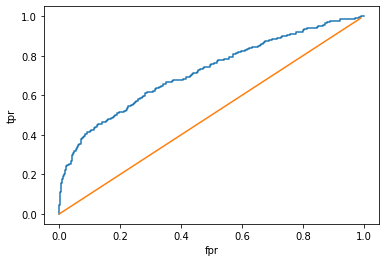

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([i for i in np.arange(0, 1, 0.01)], [i for i in np.arange(0, 1, 0.01)])

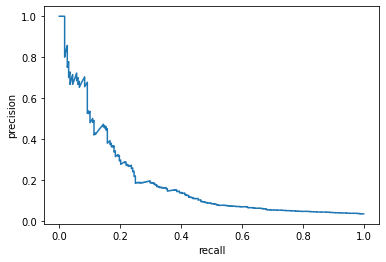

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [ ]:
np.nanmax(2 * recall * precision / (recall + precision)), thresholds[np.nanargmax(2 * recall * precision / (recall + precision))]

(0.2529274004683841, 0.39551628629434477)

In [ ]:
for i in navec.vocab:
  print(i)
  break

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
output

tensor([[-3.4993e-01, -3.0756e-01, -2.7500e-01,  1.1932e-03, -1.7987e-01,
         -1.3807e-01,  1.0722e-02,  3.0190e-01, -9.9065e-02, -1.4211e-01,
         -6.3561e-01, -1.4722e-01, -3.9479e-01, -3.7867e-01, -7.1260e-02,
          2.0672e-01,  1.2577e-01, -3.2960e-01,  3.5796e-01,  2.7854e-01,
         -4.3397e-01, -1.4973e-02, -1.9574e-01,  3.1353e-01, -2.2685e-01,
          1.9929e-02,  4.0099e-01,  1.3460e-01,  7.5548e-03,  1.5212e-01,
         -2.1347e-01, -1.2314e-01,  4.7164e-01,  2.5409e-01,  4.4845e-01,
          1.9260e-01, -2.7073e-01, -2.0794e-01,  7.3013e-01,  1.0160e-01,
         -2.6584e-01, -3.6435e-01,  7.3061e-02, -3.9773e-01, -1.0634e-01,
         -1.9774e-01, -4.3082e-02,  2.9453e-01, -6.7992e-01, -4.7794e-01,
         -3.0099e-01, -5.4821e-01,  7.8595e-02,  2.4260e-01, -3.3104e-01,
         -9.4799e-03,  4.5769e-02,  3.2028e-01,  2.1499e-01,  2.7773e-01,
          1.8513e-01, -3.6358e-01, -1.5184e-01, -1.3534e-01, -4.6190e-05,
          9.6920e-02, -6.7579e-02,  3.

AttributeError: ignored